# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

Из каталога - корня проекта:
.venv\Scripts\activate
pip install matplotlib
pip install "tornado<6"
pip install jupyter
pip install notebook
jupyter notebook a\a1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [3]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)
# Для тренировки: образы и метки; для теста: образы и метки

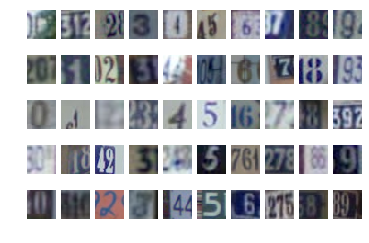

In [4]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [5]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s

# Создали массив на основе массива меток, в котором (по кол-ву элементов для треннировки)
# true - это или 0 или 9
binary_train_mask = (train_y == 0) | (train_y == 9)
# print(train_y)
# display(binary_train_mask)
# print(binary_train_mask.shape)

# На основе (реальной и правдивой) маски поместили образы цифр 0 или 9 в
# тренировочный сет binary_train_X
#
# Подготовили базу образов для анализа с числами 0 или 9
binary_train_X = train_X[binary_train_mask]
# display(binary_train_X)
# print(binary_train_X.shape)
# # Получилось 131 образ 0 или 9

# Подготовили (правдивую) базу образов для анализа с 0 (binary_train_y)
binary_train_y = train_y[binary_train_mask] == 0

# Тоже самое проделали с тестовой базой образов
binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [6]:
binary_test_X.shape

(10, 3072)

In [7]:
binary_train_X.shape

(150, 3072)

In [8]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
# Задали k, задали образы с 0 и 9, задали образы с 0
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`

In [9]:
# implement compute_distances_two_loops in knn.py
# display(binary_test_X)
# print(binary_test_X.shape)
# Получили расстояния между тренировочными образами и тестовыми, 2 цикла
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [10]:
# implement compute_distances_one_loop in knn.py
# Получили расстояния между тренировочными образами и тестовыми, 1 цикл
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))
# print(dists.shape)

In [11]:
# implement compute_distances_no_loops in knn.py
# Получили расстояния между от 0 тренировочными образами и тестовыми, без циклов
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [12]:
# Lets look at the performance difference
# Замерили производительность с 1 циклом быстрее всего
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

21.7 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.2 ms ± 57.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.1 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
# implement predict_labels_binary in knn.py
# Получили булевый массив отклонений от K значений 0 тестовых образов 
prediction = knn_classifier.predict(binary_test_X)

In [14]:
#  implement binary_classification_metrics in metrics.py
display(prediction)
# print(prediction.shape)
display(binary_test_y)
# print(binary_test_y.shape)
# Массив отклонений расстояний от 0 (меньше K) тестовых образов, массив правдивых меток
accuracy, precision, recall, f1 = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

array([ True, False, False, False,  True,  True,  True,  True,  True,
       False])

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True])

KNN with k = 1
Accuracy: 1.43, Precision: 1.50, Recall: 1.00, F1: 1.20


In [15]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

accuracy, precision, recall, f1 = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 1.29, Precision: 1.67, Recall: 1.80, F1: 1.00


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение k! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [29]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

# split the training data in 5 folds and store them in train_folds_X/train_folds_y
train_folds_X = np.split(train_X, num_folds)
train_folds_y = np.split(train_y, num_folds)

print(len(train_folds_X))

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for i_k in k_choices:
    # perform cross-validation
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1
    sum_f1 = 0
    print('i_k= '+str(i_k))
    for i_num_folds in range(num_folds):
        print('i_num_folds= '+str(i_num_folds))
        knn_classifier_Kn = KNN(k=i_k)
        
        cross_train_X =  np.concatenate(np.asarray([x for i,x in enumerate(train_folds_X) if i!= i_num_folds]), axis=0)
        print(cross_train_X.shape)
        cross_train_y =  np.concatenate(np.asarray([x for i,x in enumerate(train_folds_y) if i!= i_num_folds]), axis=0)
        
        test_X = np.asarray(train_folds_X[i_num_folds])
        print(test_X.shape)
        test_y = np.asarray(train_folds_y[i_num_folds])
        
        cross_binary_train_mask = (cross_train_y == 0) | (cross_train_y == 9)
        
        # Подготовили базу образов для анализа с числами 0 или 9
        cross_binary_train_X = cross_train_X[cross_binary_train_mask]

        # Подготовили (правдивую) базу образов для анализа с 0 (binary_train_y)
        cross_binary_train_y = cross_train_y[cross_binary_train_mask] == 0

        # Тоже самое проделали с тестовой базой образов
        binary_test_mask = (test_y == 0) | (test_y == 9)
        binary_test_X = test_X[binary_test_mask]
        binary_test_y = test_y[binary_test_mask] == 0

        # Reshape to 1-dimensional array [num_samples, 32*32*3]
        cross_binary_train_X = cross_binary_train_X.reshape(cross_binary_train_X.shape[0], -1)
        binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)
        
        print(cross_binary_train_X.shape)
        print(binary_test_X.shape)
               
        knn_classifier_Kn.fit(cross_binary_train_X, cross_binary_train_y)
        prediction = knn_classifier_Kn.predict(binary_test_X)
        accuracy, precision, recall, f1 = binary_classification_metrics(prediction, binary_test_y)
        print('f1= '+str(f1)+' precision= '+str(precision)+' recall= '+str(recall))
        sum_f1+=f1
    sr_f1 = sum_f1/num_folds
    print('sr_f1= '+str(sr_f1))
    k_to_f1[i_k]= sr_f1

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

5
i_k= 1
i_num_folds= 0
(800, 32, 32, 3)
(200, 32, 32, 3)
(115, 3072)
(35, 3072)
f1= 1.0 precision= 1.0294117647058822 recall= 1.0588235294117647
i_num_folds= 1
(800, 32, 32, 3)
(200, 32, 32, 3)
(121, 3072)
(29, 3072)
f1= 1.0 precision= 1.3181818181818181 recall= 1.5833333333333333
i_num_folds= 2
(800, 32, 32, 3)
(200, 32, 32, 3)
(122, 3072)
(28, 3072)
f1= 1.0 precision= 0.9333333333333333 recall= 0.8571428571428571
i_num_folds= 3
(800, 32, 32, 3)
(200, 32, 32, 3)
(129, 3072)
(21, 3072)
f1= 1.0 precision= 1.3125 recall= 1.8333333333333333
i_num_folds= 4
(800, 32, 32, 3)
(200, 32, 32, 3)
(113, 3072)
(37, 3072)
f1= 1.0 precision= 0.8809523809523809 recall= 0.7727272727272727
sr_f1= 1.0
i_k= 2
i_num_folds= 0
(800, 32, 32, 3)
(200, 32, 32, 3)
(115, 3072)
(35, 3072)
f1= 1.0 precision= 0.875 recall= 0.782608695652174
i_num_folds= 1
(800, 32, 32, 3)
(200, 32, 32, 3)
(121, 3072)
(29, 3072)
f1= 1.0 precision= 0.90625 recall= 0.8636363636363636
i_num_folds= 2
(800, 32, 32, 3)
(200, 32, 32, 3)
(1

### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [ ]:
# TODO Set the best k to the best value found by cross-validation
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [ ]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [ ]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [ ]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [ ]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce accuracy metric on the validation dataset
    # Average accuracy from all the folds and write it into k_to_accuracy
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [ ]:
# TODO Set the best k as a best from computed
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)